# Plot Interpolated Data

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt


In [14]:
# open combined_array_20231025.nc
combined_array = xr.open_dataset('../combined_array_20231025.nc')
combined_array

<xarray.Dataset>
Dimensions:  (time: 9138, x: 10, y: 10)
Coordinates:
  * x        (x) int64 -300475 -295475 -290475 ... -265475 -260475 -255475
  * y        (y) int64 -2281975 -2276975 -2271975 ... -2246975 -2241975 -2236975
  * time     (time) int64 19980101 19980102 19980103 ... 20230130 20230131
Data variables:
    chla     (time, x, y) float64 ...

In [15]:
mean = combined_array.chla.mean().values
std = combined_array.chla.std().values
min_val = combined_array.chla.min().values
max_val = combined_array.chla.max().values
quantiles = combined_array.chla.quantile([0.25, 0.5, 0.75]).values

print(f"mean: {mean}")
print(f"std: {std}")
print(f"min: {min_val}")
print(f"25%: {quantiles[0]}")
print(f"50%: {quantiles[1]}")
print(f"75%: {quantiles[2]}")
print(f"max: {max_val}")
print(f"\nextreme outliers (mean+3*sigma): {mean + 3 * std}")

mean: 1.2503322366863996
std: 2.3146844314679744
min: 0.0369437001645565
25%: 0.4372021423946177
50%: 0.6419446174583145
75%: 1.0822828962460251
max: 74.833556888862

extreme outliers (mean+3*sigma): 8.194385531090322


In [16]:
combined_array['chla'].values[combined_array['chla'].values > 10] = np.nan

In [22]:
# get a new array called averages where chla is averaged over time
chla_grid_averages = combined_array.chla.mean(dim='time')

# print(chla_grid_averages)
print(chla_grid_averages.shape)

(10, 10)


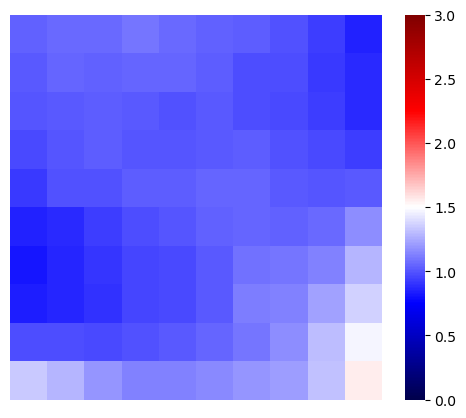

In [21]:
# plot averages as a heatmap 
plt.figure(figsize=(6, 5))
sns.heatmap(chla_grid_averages, cmap='seismic', vmin=0, vmax=3)

# Remove x and y labels and ticks
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

plt.show()
plt.close()

# Annual groups

In [55]:
# create 'time.year' with the first 4 characters of time 
combined_array['time.year'] = combined_array.time.astype(str).str[:4]
grouped = combined_array.groupby('time.year')
print("1999 mean:", grouped['1999'].chla.mean().item())

1999 mean: 0.6024765270177478


In [56]:
annual_averages = {}
annual_median = {}
annual_stddev = {}
for name, group in grouped:
    annual_averages[name] = group['chla'].mean().item()
    annual_median[name] = group['chla'].median().item()
    annual_stddev[name] = group['chla'].std().item()

# drop 2023 from the dictionaries bc its incomplete
annual_averages.pop('2023')
annual_median.pop('2023')
annual_stddev.pop('2023')

nan

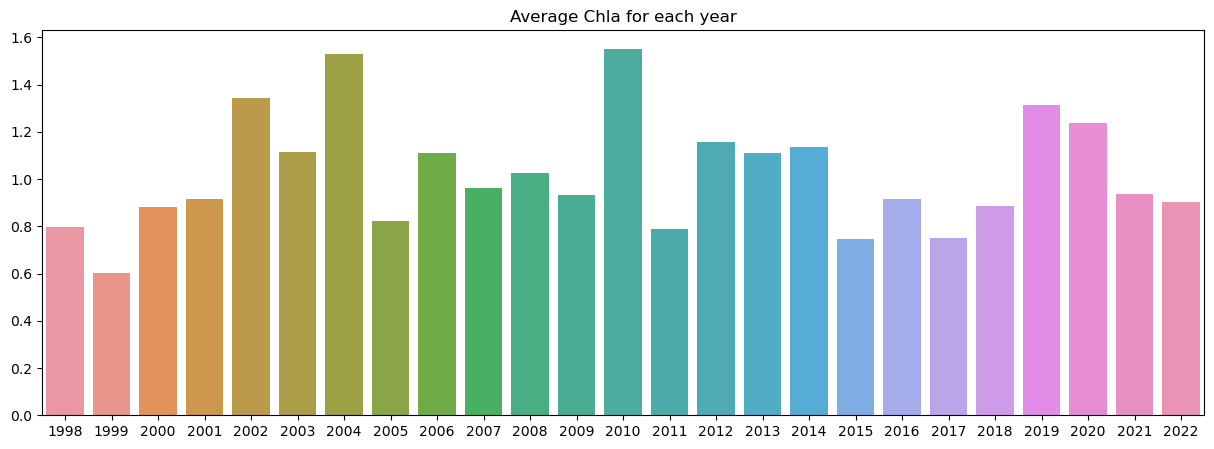

In [57]:
plt.figure(figsize=(15, 5))
sns.barplot(x=list(annual_averages.keys()), y=list(annual_averages.values()))
plt.title('Average Chla for each year')
plt.show()
plt.close()


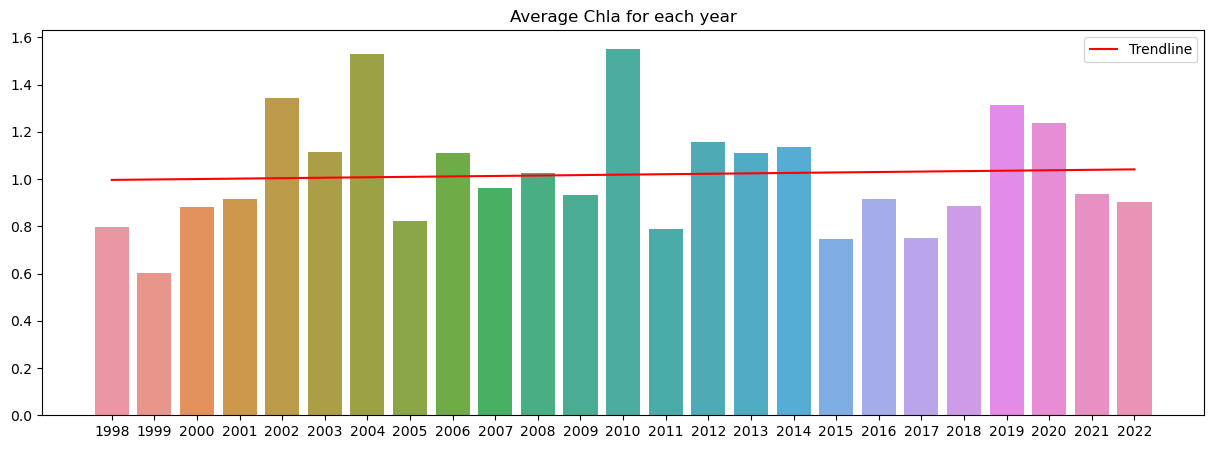

In [28]:
# with trendline
y = list(annual_averages.values())

# Generate x values
x = np.arange(len(y))

# Calculate trendline
coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

# Generate y values for the trendline
y_trend = trendline(x)

# Plot the averages for each year (keys) in averages as bar plot with a trendline
plt.figure(figsize=(15, 5))
sns.barplot(x=list(annual_averages.keys()), y=y)
plt.plot(x, y_trend, color='red', label='Trendline')
plt.title('Average Chla for each year')
plt.legend()
plt.show()
plt.close()

## plotting trends

In [58]:
# for time in combined_array.time: get the mean of chla for each time
daily_averages = {}
daily_median = {}
daily_stddev = {}
for time in combined_array.time.values:
    daily_averages[time] = combined_array.chla.sel(time=time).mean().item()
    daily_median[time] = combined_array.chla.sel(time=time).median().item()
    daily_stddev[time] = combined_array.chla.sel(time=time).std().item()

convert_time = lambda x: dt.datetime.strptime(str(x), '%Y%m%d')

daily_averages_dt = {convert_time(key): value for key, value in daily_averages.items()}
daily_median_dt = {convert_time(key): value for key, value in daily_median.items()}
daily_stddev_dt = {convert_time(key): value for key, value in daily_stddev.items()}

# print(daily_averages_dt)
# print the type of the keys of daily_averages_dt
# print(list(daily_averages_dt.keys())[0])

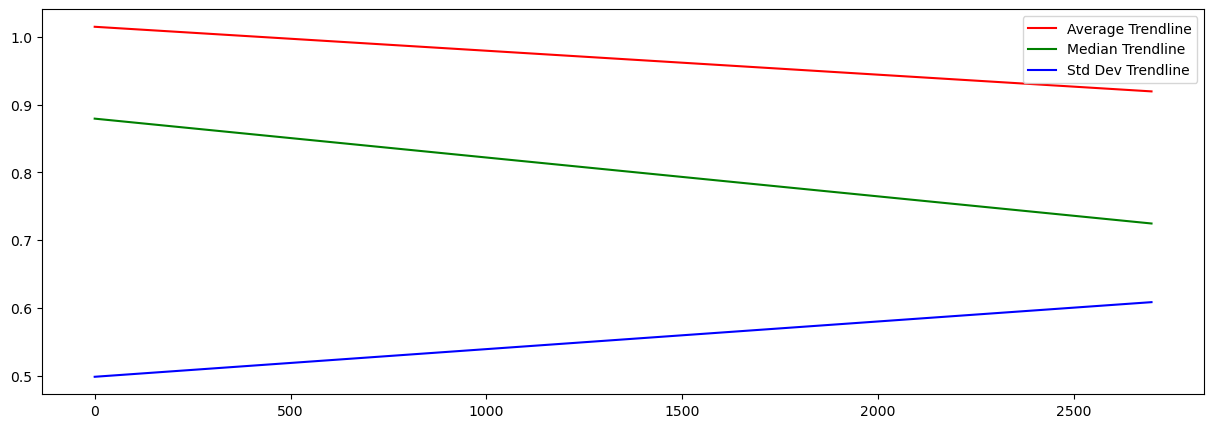

In [31]:
# Convert the dictionary values to lists and remove NaN values
y_avg = [v for v in daily_averages.values() if not np.isnan(v)]
y_med = [v for v in daily_median.values() if not np.isnan(v)]
y_std = [v for v in daily_stddev.values() if not np.isnan(v)]

# Generate x values
x_avg = np.arange(len(y_avg))
x_med = np.arange(len(y_med))
x_std = np.arange(len(y_std))

# Calculate trendlines
coefficients_avg = np.polyfit(x_avg, y_avg, 1)
trendline_avg = np.poly1d(coefficients_avg)

coefficients_med = np.polyfit(x_med, y_med, 1)
trendline_med = np.poly1d(coefficients_med)

coefficients_std = np.polyfit(x_std, y_std, 1)
trendline_std = np.poly1d(coefficients_std)

# Generate y values for the trendlines
y_trend_avg = trendline_avg(x_avg)
y_trend_med = trendline_med(x_med)
y_trend_std = trendline_std(x_std)

# Plot trendlines
plt.figure(figsize=(15, 5))
plt.plot(x_avg, y_trend_avg, color='red', label='Average Trendline')
plt.plot(x_med, y_trend_med, color='green', label='Median Trendline')
plt.plot(x_std, y_trend_std, color='blue', label='Std Dev Trendline')
plt.legend()
plt.show()
plt.close()

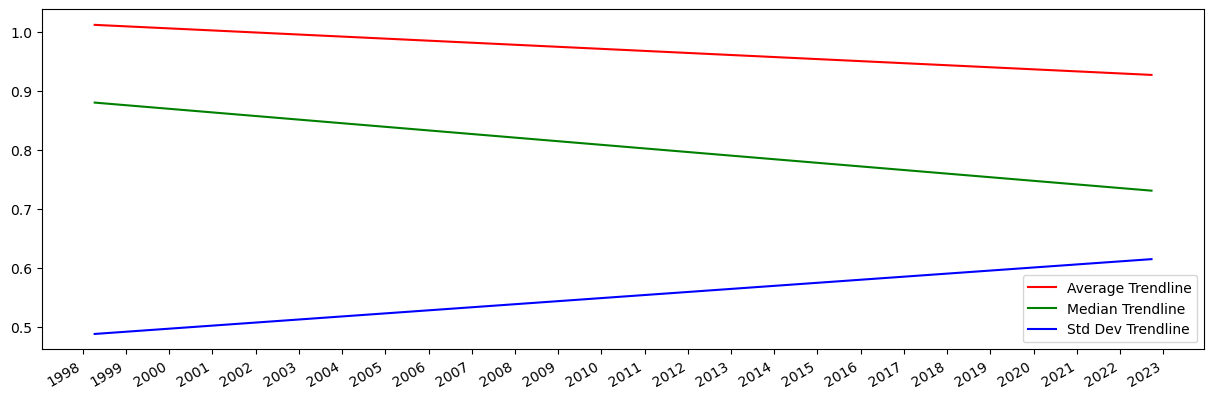

In [32]:
import matplotlib.dates as mdates
from datetime import datetime

# Convert the dictionary values to lists and remove NaN values
y_avg = [v for v in daily_averages.values() if not np.isnan(v)]
y_med = [v for v in daily_median.values() if not np.isnan(v)]
y_std = [v for v in daily_stddev.values() if not np.isnan(v)]

# Generate x values
x_avg = [datetime.strptime(str(k), '%Y%m%d') for k, v in daily_averages.items() if not np.isnan(v)]
x_med = [datetime.strptime(str(k), '%Y%m%d') for k, v in daily_median.items() if not np.isnan(v)]
x_std = [datetime.strptime(str(k), '%Y%m%d') for k, v in daily_stddev.items() if not np.isnan(v)]

# Convert dates to numbers
x_avg_num = mdates.date2num(x_avg)
x_med_num = mdates.date2num(x_med)
x_std_num = mdates.date2num(x_std)

# Calculate trendlines
coefficients_avg = np.polyfit(x_avg_num, y_avg, 1)
trendline_avg = np.poly1d(coefficients_avg)

coefficients_med = np.polyfit(x_med_num, y_med, 1)
trendline_med = np.poly1d(coefficients_med)

coefficients_std = np.polyfit(x_std_num, y_std, 1)
trendline_std = np.poly1d(coefficients_std)

# Generate y values for the trendlines
y_trend_avg = trendline_avg(x_avg_num)
y_trend_med = trendline_med(x_med_num)
y_trend_std = trendline_std(x_std_num)

# Plot trendlines
plt.figure(figsize=(15, 5))
plt.plot(x_avg, y_trend_avg, color='red', label='Average Trendline')
plt.plot(x_med, y_trend_med, color='green', label='Median Trendline')
plt.plot(x_std, y_trend_std, color='blue', label='Std Dev Trendline')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # show only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # set interval to 1 year
plt.gcf().autofmt_xdate()  # rotate dates for better display

plt.legend()
plt.show()
plt.close()

# By Pixel

In [60]:
# group combined_array by year
annual_grouped = combined_array.groupby('time.year')

In [62]:
# grouped['1999'].chla.mean()

# for grouped['1999'] get the time dim mean of chla for each x,y coordinate
annual_averages = {}
annual_medians = {}
annual_stddevs = {}
for name, group in annual_grouped:
    annual_averages[name] = group['chla'].mean(dim='time').values
    annual_medians[name] = group['chla'].median(dim='time').values
    annual_stddevs[name] = group['chla'].std(dim='time').values

annual_averages.pop('2023')
annual_medians.pop('2023')
annual_stddevs.pop('2023')

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

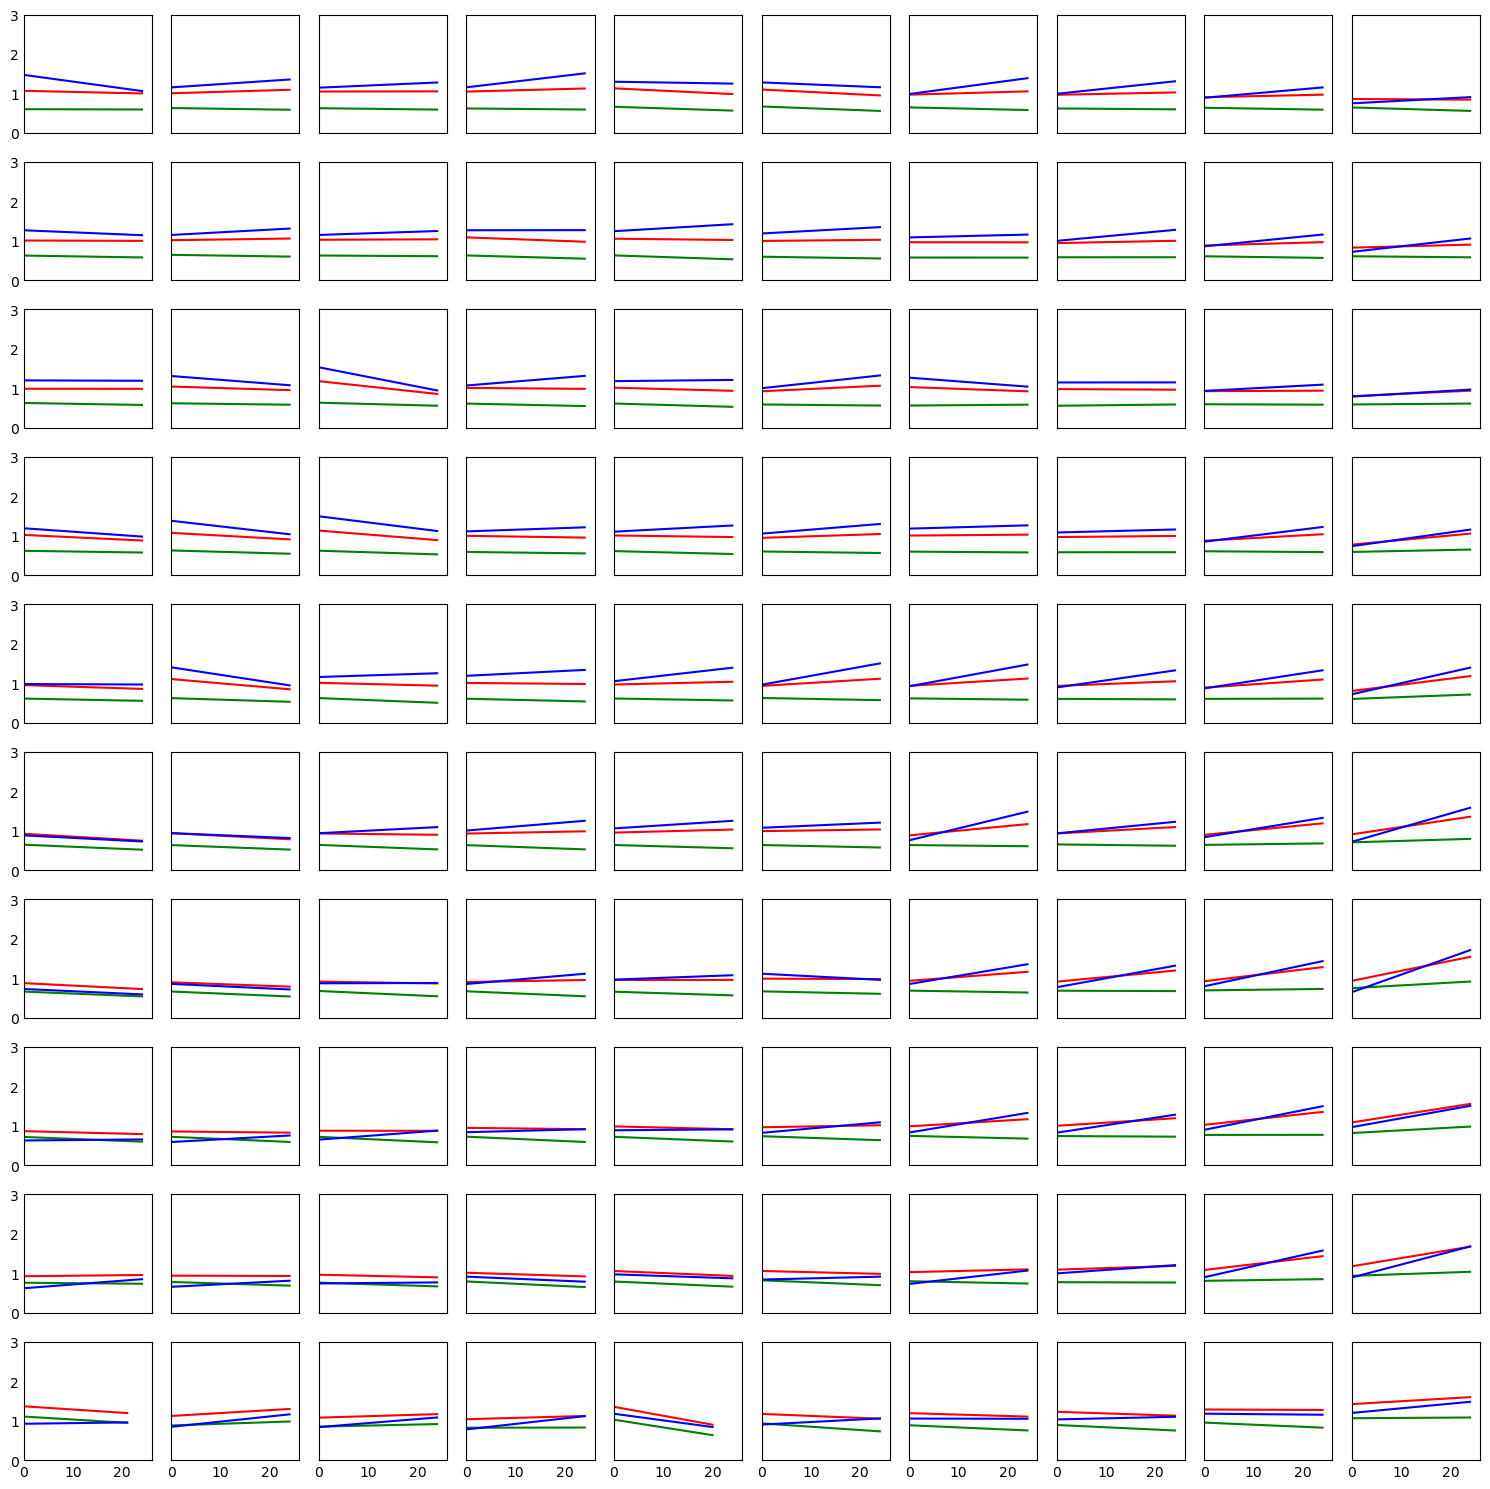

In [63]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))

# Iterate over each subplot
for i in range(10):
    for j in range(10):
        # Extract the i,j element from each dictionary value
        y_avg = [v[i, j] for v in annual_averages.values() if not np.isnan(v[i, j])]
        y_med = [v[i, j] for v in annual_medians.values() if not np.isnan(v[i, j])]
        y_std = [v[i, j] for v in annual_stddevs.values() if not np.isnan(v[i, j])]

        # Generate x values
        x_avg = np.arange(len(y_avg))
        x_med = np.arange(len(y_med))
        x_std = np.arange(len(y_std))

        # Calculate trendlines
        coefficients_avg = np.polyfit(x_avg, y_avg, 1)
        trendline_avg = np.poly1d(coefficients_avg)

        coefficients_med = np.polyfit(x_med, y_med, 1)
        trendline_med = np.poly1d(coefficients_med)

        coefficients_std = np.polyfit(x_std, y_std, 1)
        trendline_std = np.poly1d(coefficients_std)

        # Generate y values for the trendlines
        y_trend_avg = trendline_avg(x_avg)
        y_trend_med = trendline_med(x_med)
        y_trend_std = trendline_std(x_std)

        # Plot trendlines on the i,j subplot
        axs[i, j].plot(x_avg, y_trend_avg, color='red')
        axs[i, j].plot(x_med, y_trend_med, color='green')
        axs[i, j].plot(x_std, y_trend_std, color='blue')

        # Set x and y limits
        axs[i, j].set_xlim([0, 26])
        axs[i, j].set_ylim([0, 3])

        # Control display of ticks
        axs[i, j].tick_params(labelbottom=False, labelleft=False, length=0)

# Enable labels for bottom row and leftmost column
for ax in axs[9, :]:
    ax.tick_params(labelbottom=True)
for ax in axs[:, 0]:
    ax.tick_params(labelleft=True)

plt.tight_layout()
plt.show()
plt.close()

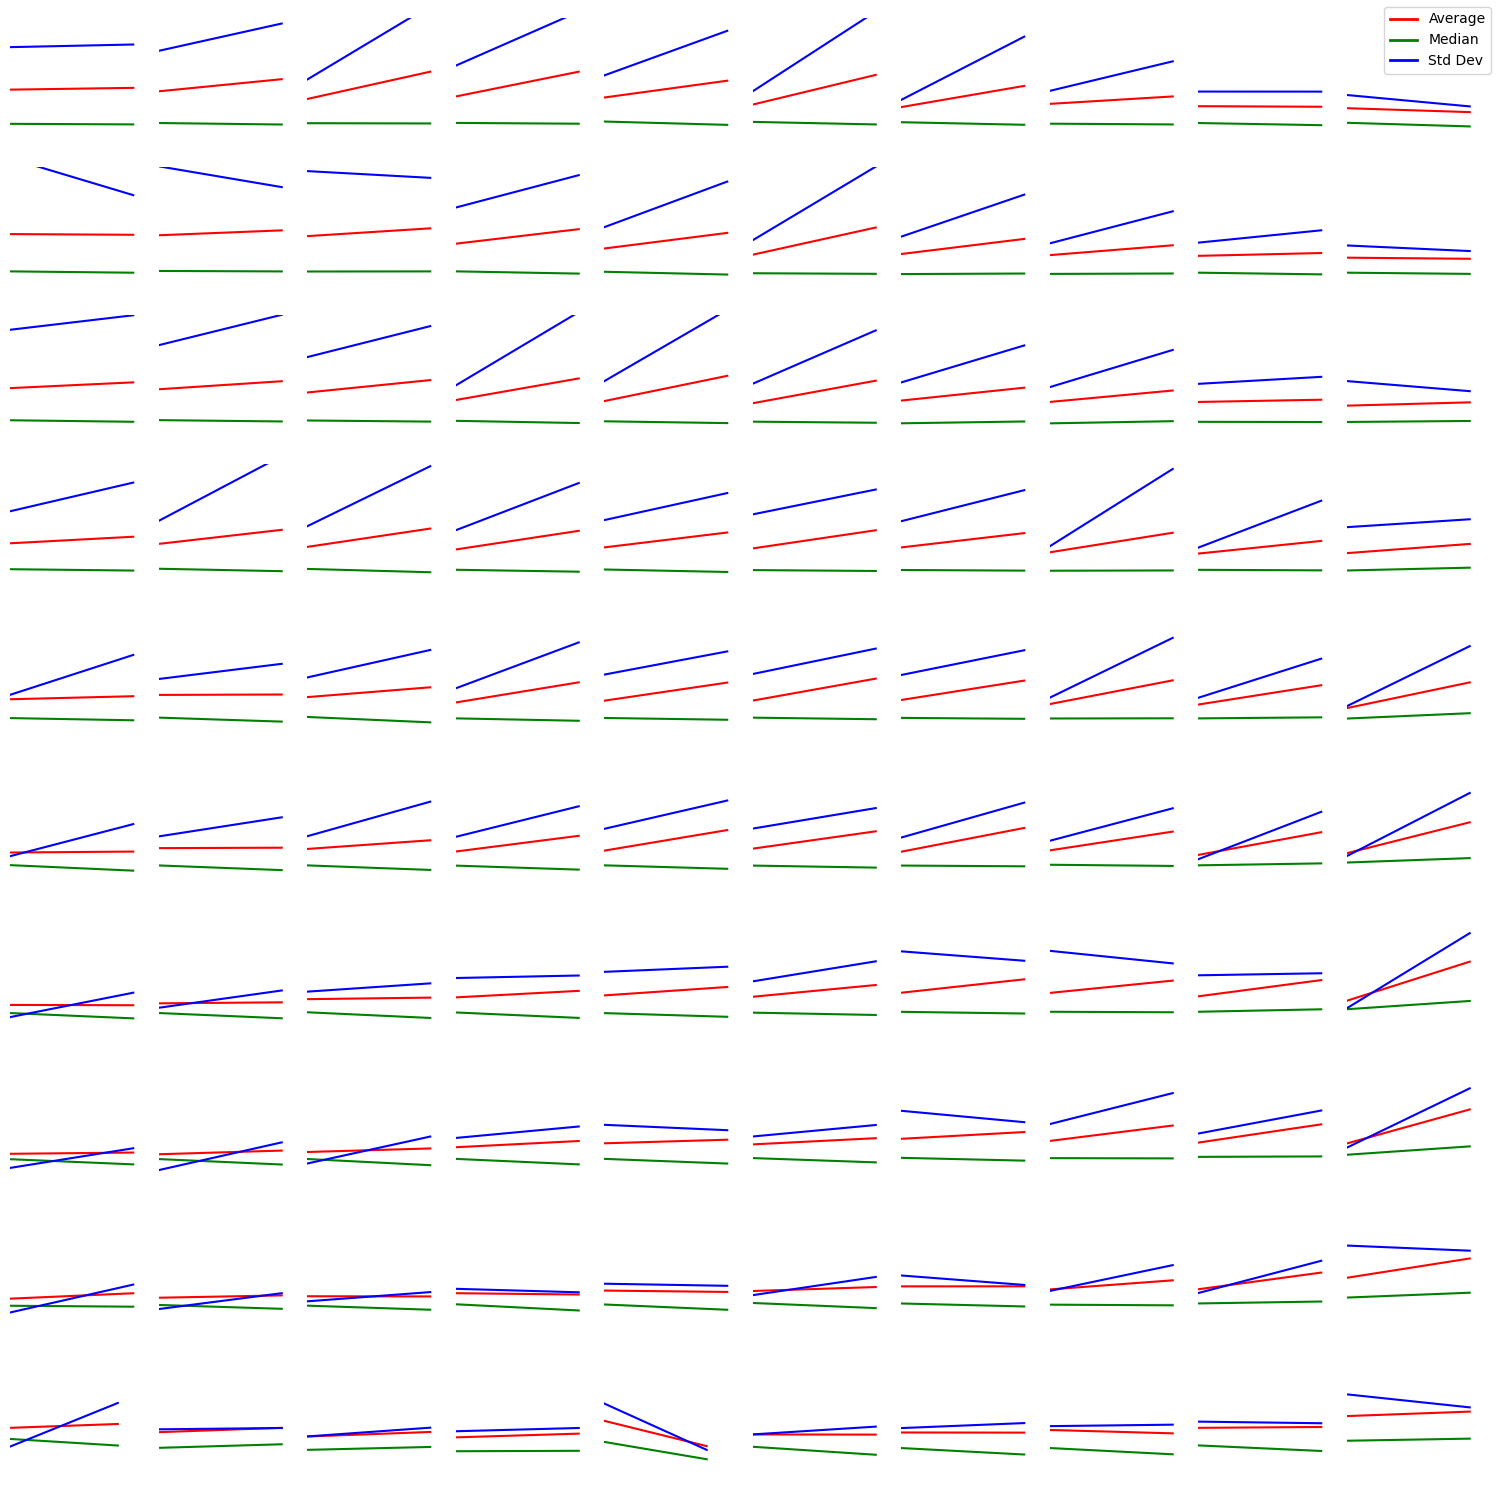

In [239]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))

# Create a custom legend
custom_lines = [plt.Line2D([0], [0], color='red', lw=2),
                plt.Line2D([0], [0], color='green', lw=2),
                plt.Line2D([0], [0], color='blue', lw=2)]
fig.legend(custom_lines, ['Average', 'Median', 'Std Dev'], loc='upper right')

# Iterate over each subplot
for i in range(10):
    for j in range(10):
        # Extract the i,j element from each dictionary value
        y_avg = [v[i, j] for v in annual_averages.values() if not np.isnan(v[i, j])]
        y_med = [v[i, j] for v in annual_medians.values() if not np.isnan(v[i, j])]
        y_std = [v[i, j] for v in annual_stddevs.values() if not np.isnan(v[i, j])]

        # Generate x values
        x_avg = np.arange(len(y_avg))
        x_med = np.arange(len(y_med))
        x_std = np.arange(len(y_std))

        # Calculate trendlines
        coefficients_avg = np.polyfit(x_avg, y_avg, 1)
        trendline_avg = np.poly1d(coefficients_avg)

        coefficients_med = np.polyfit(x_med, y_med, 1)
        trendline_med = np.poly1d(coefficients_med)

        coefficients_std = np.polyfit(x_std, y_std, 1)
        trendline_std = np.poly1d(coefficients_std)

        # Generate y values for the trendlines
        y_trend_avg = trendline_avg(x_avg)
        y_trend_med = trendline_med(x_med)
        y_trend_std = trendline_std(x_std)

        # Plot trendlines on the i,j subplot
        axs[i, j].plot(x_avg, y_trend_avg, color='red')
        axs[i, j].plot(x_med, y_trend_med, color='green')
        axs[i, j].plot(x_std, y_trend_std, color='blue')

        # Set x and y limits
        axs[i, j].set_xlim([0, 26])
        axs[i, j].set_ylim([0, 3])

        # Control display of ticks
        # axs[i, j].tick_params(labelbottom=False, labelleft=False, length=0)

        # # Hide grid border
        # axs[i, j].spines['top'].set_visible(False)
        # axs[i, j].spines['right'].set_visible(False)
        # axs[i, j].spines['bottom'].set_visible(False)
        # axs[i, j].spines['left'].set_visible(False)

        # Hide labels, ticks, and borders
        axs[i, j].tick_params(labelbottom=False, labelleft=False, length=0)
        axs[i, j].spines['top'].set_visible(False)
        axs[i, j].spines['right'].set_visible(False)
        axs[i, j].spines['bottom'].set_visible(False)
        axs[i, j].spines['left'].set_visible(False)

# # Enable labels for bottom row and leftmost column
# for ax in axs[9, :]:
#     ax.tick_params(labelbottom=True)
#     ax.spines['bottom'].set_visible(True)
# for ax in axs[:, 0]:
#     ax.tick_params(labelleft=True)
#     ax.spines['left'].set_visible(True)

plt.tight_layout()
plt.show()
plt.close()

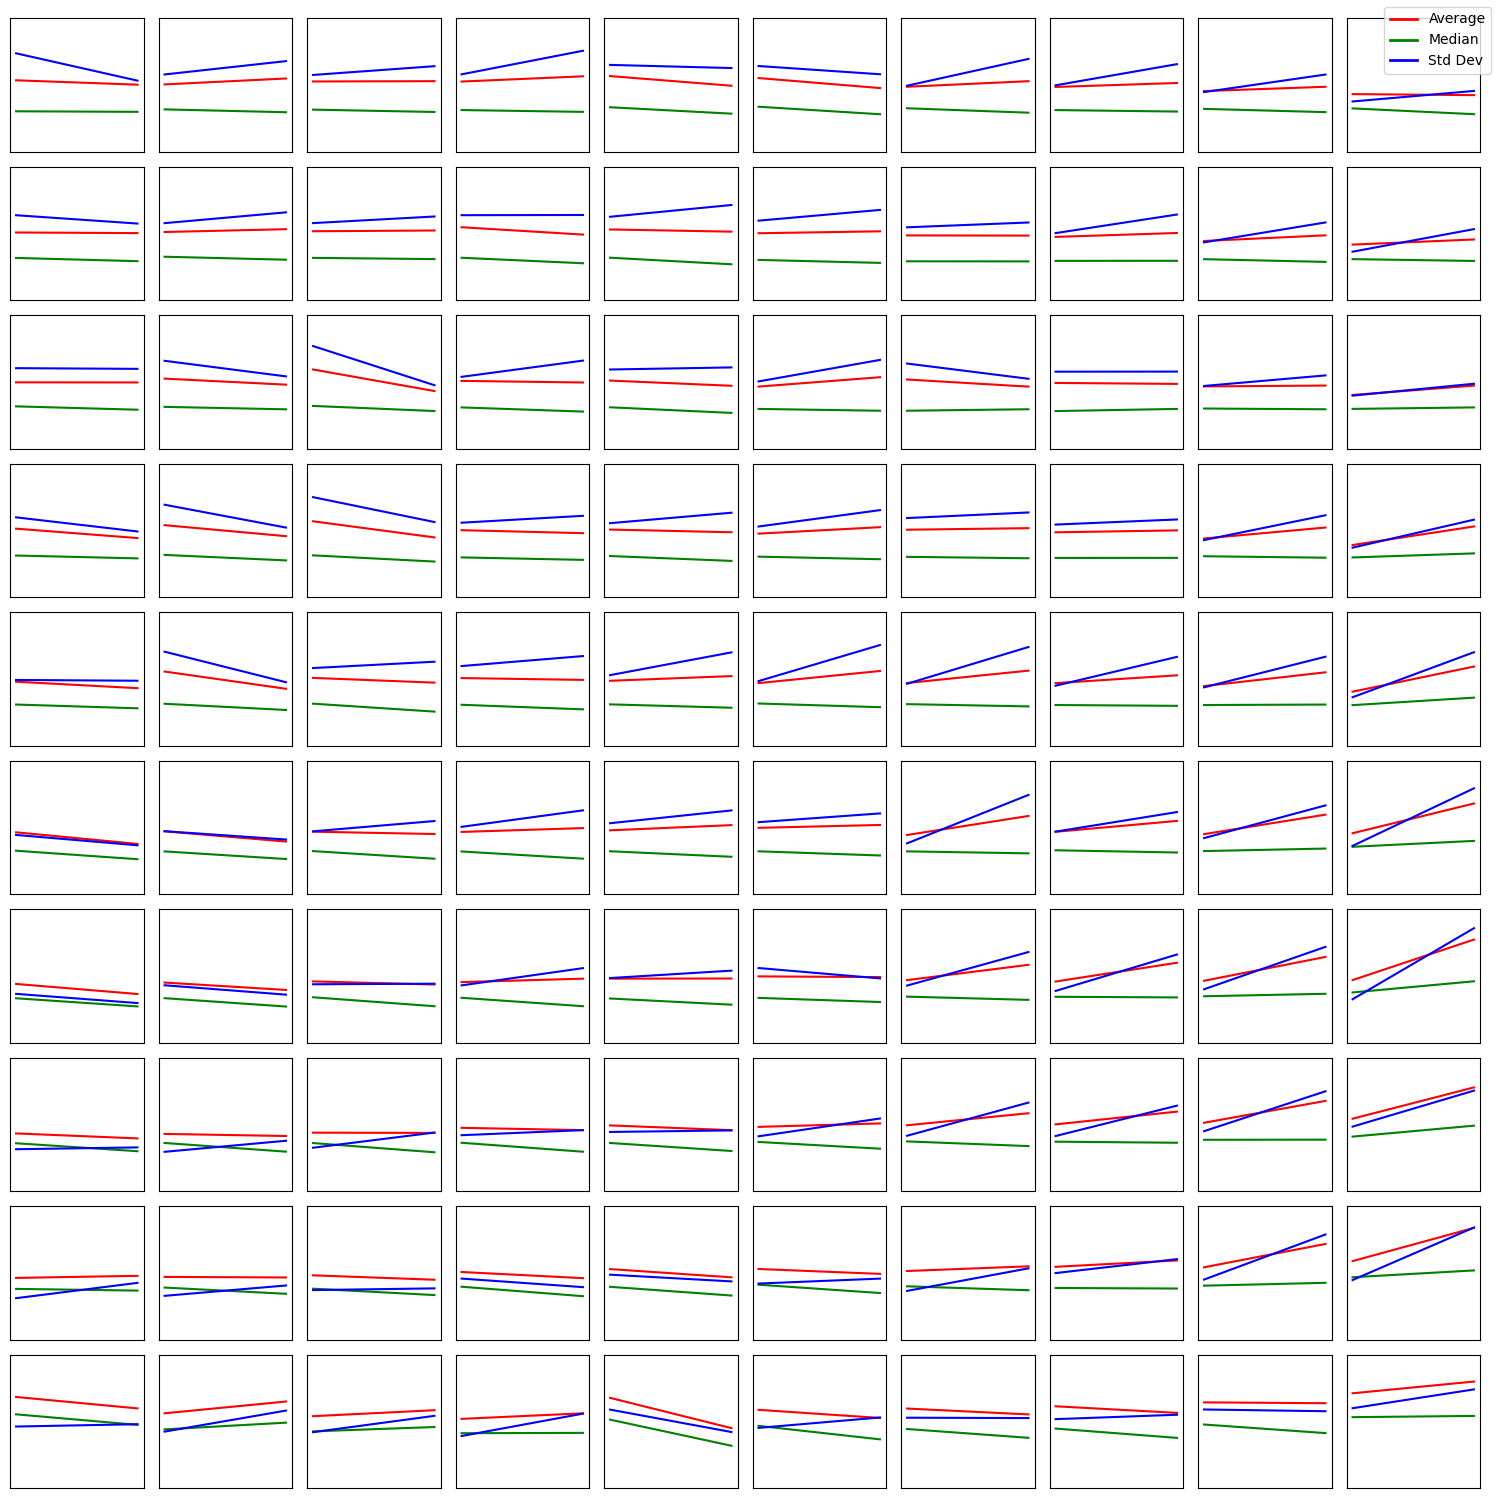

In [47]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))

# Create a custom legend
custom_lines = [plt.Line2D([0], [0], color='red', lw=2),
                plt.Line2D([0], [0], color='green', lw=2),
                plt.Line2D([0], [0], color='blue', lw=2)]
fig.legend(custom_lines, ['Average', 'Median', 'Std Dev'], loc='upper right')

# Iterate over each subplot
for i in range(10):
    for j in range(10):
        # Extract the i,j element from each dictionary value
        y_avg = [v[i, j] for v in annual_averages.values() if not np.isnan(v[i, j])]
        y_med = [v[i, j] for v in annual_medians.values() if not np.isnan(v[i, j])]
        y_std = [v[i, j] for v in annual_stddevs.values() if not np.isnan(v[i, j])]

        # Generate x values
        x_avg = np.arange(len(y_avg))
        x_med = np.arange(len(y_med))
        x_std = np.arange(len(y_std))

        # Calculate trendlines
        coefficients_avg = np.polyfit(x_avg, y_avg, 1)
        trendline_avg = np.poly1d(coefficients_avg)

        coefficients_med = np.polyfit(x_med, y_med, 1)
        trendline_med = np.poly1d(coefficients_med)

        coefficients_std = np.polyfit(x_std, y_std, 1)
        trendline_std = np.poly1d(coefficients_std)

        # Generate y values for the trendlines
        y_trend_avg = trendline_avg(x_avg)
        y_trend_med = trendline_med(x_med)
        y_trend_std = trendline_std(x_std)

        # Plot trendlines on the i,j subplot
        axs[i, j].plot(x_avg, y_trend_avg, color='red')
        axs[i, j].plot(x_med, y_trend_med, color='green')
        axs[i, j].plot(x_std, y_trend_std, color='blue')

        # Set x and y limits
        # axs[i, j].set_xlim([0, 25])
        axs[i, j].set_ylim([0, 2])

        # Control display of ticks
        # axs[i, j].tick_params(labelbottom=False, labelleft=False, length=0)

        # # Hide grid border
        # axs[i, j].spines['top'].set_visible(False)
        # axs[i, j].spines['right'].set_visible(False)
        # axs[i, j].spines['bottom'].set_visible(False)
        # axs[i, j].spines['left'].set_visible(False)

        # Hide labels, ticks, and borders
        axs[i, j].tick_params(labelbottom=False, labelleft=False, length=0)
        # axs[i, j].spines['top'].set_visible(False)
        # axs[i, j].spines['right'].set_visible(False)
        # axs[i, j].spines['bottom'].set_visible(False)
        # axs[i, j].spines['left'].set_visible(False)

# # Enable labels for bottom row and leftmost column
# for ax in axs[9, :]:
#     ax.tick_params(labelbottom=True)
#     ax.spines['bottom'].set_visible(True)
# for ax in axs[:, 0]:
#     ax.tick_params(labelleft=True)
#     ax.spines['left'].set_visible(True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.show()
plt.close()

### annual bar plots

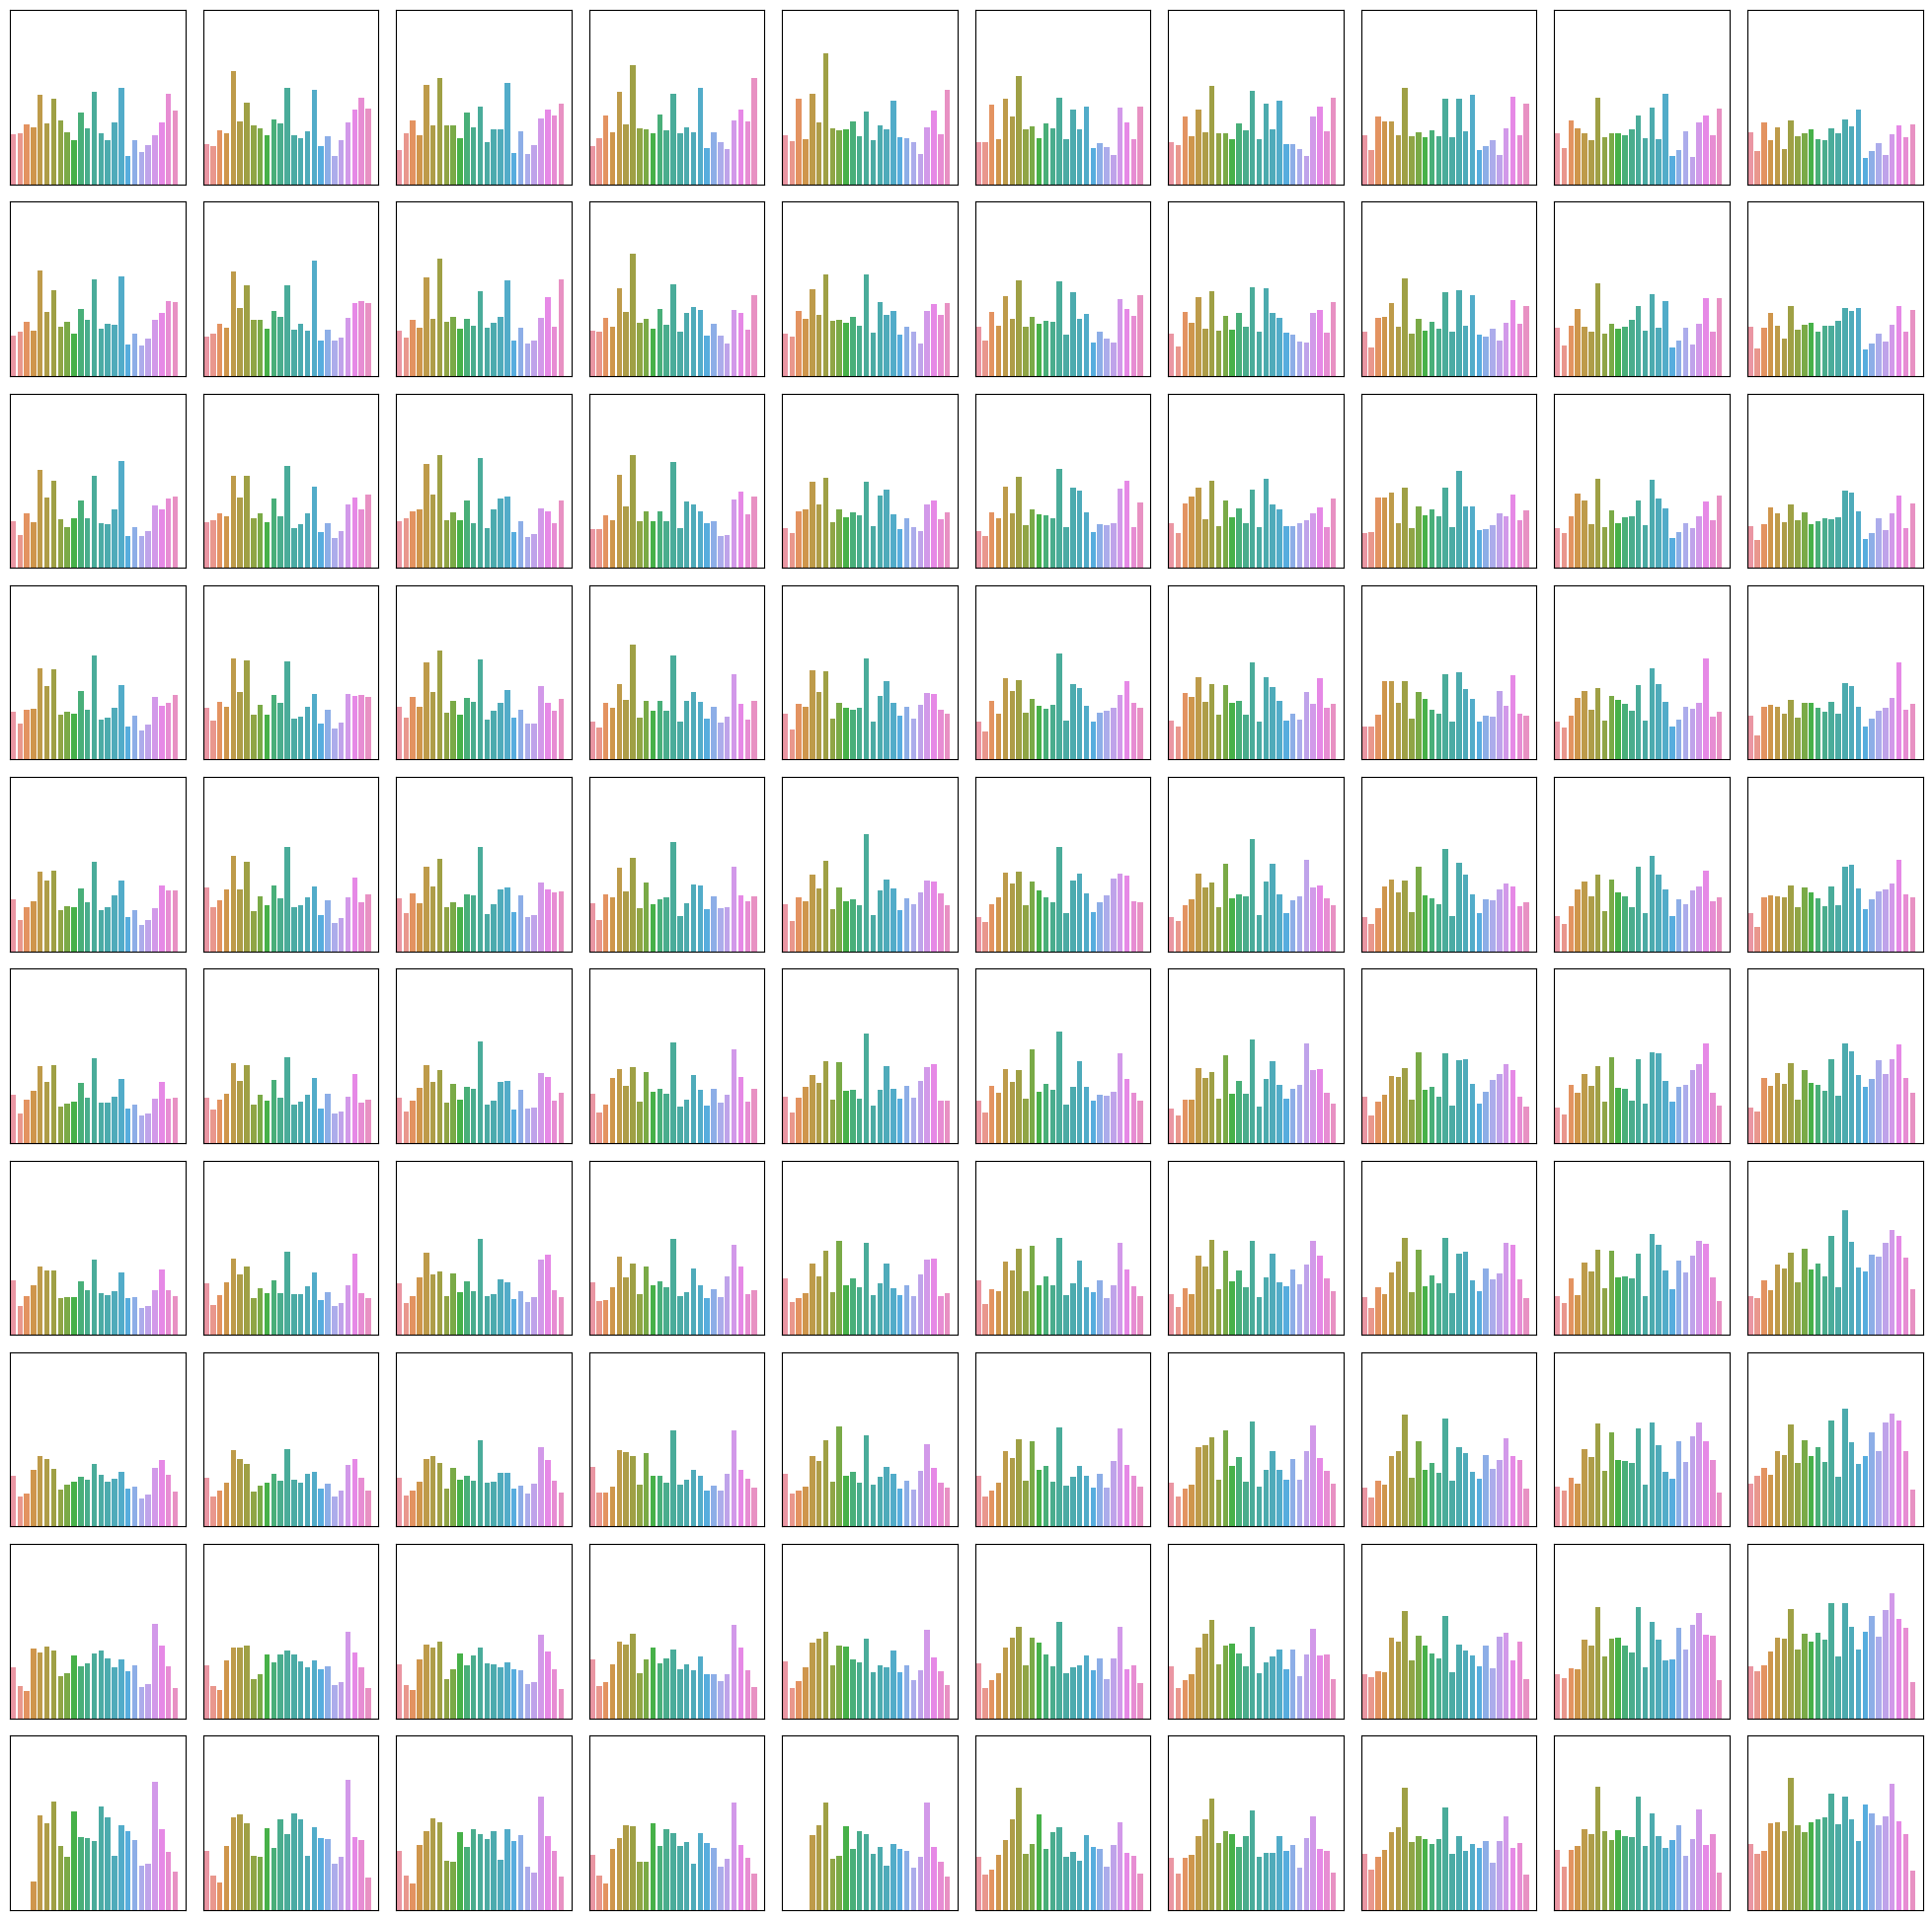

<Figure size 640x480 with 0 Axes>

In [44]:
# Create a 10x10 grid of subplots
fig, axs = plt.subplots(10, 10, figsize=(25, 25))
# plt.subplots_adjust(top=0.9)

# Add title and subtitle
# fig.suptitle('Average Annual Chlorophyll-a\n1998-2023', fontsize=16)

# Iterate over each subplot
for i in range(10):
    for j in range(10):
        # Extract the i,j element from each dictionary value
        y = [v[i, j] for v in annual_averages.values()]

        # Generate x values
        x = list(annual_averages.keys())

        # Plot bar graph on the i,j subplot
        sns.barplot(x=x, y=y, ax=axs[i, j])

        # Remove title, xticks, xlabels, yticks, ylabels
        axs[i, j].set_title('')
        axs[i, j].set_xticks([])
        axs[i, j].set_xlabel('')
        axs[i, j].set_yticks([])
        axs[i, j].set_ylabel('')

        # Set y limit
        axs[i, j].set_ylim([0, 3])

# Adjust spacing between subplots
# plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()
# save the figure
plt.savefig('annual_averages.png')

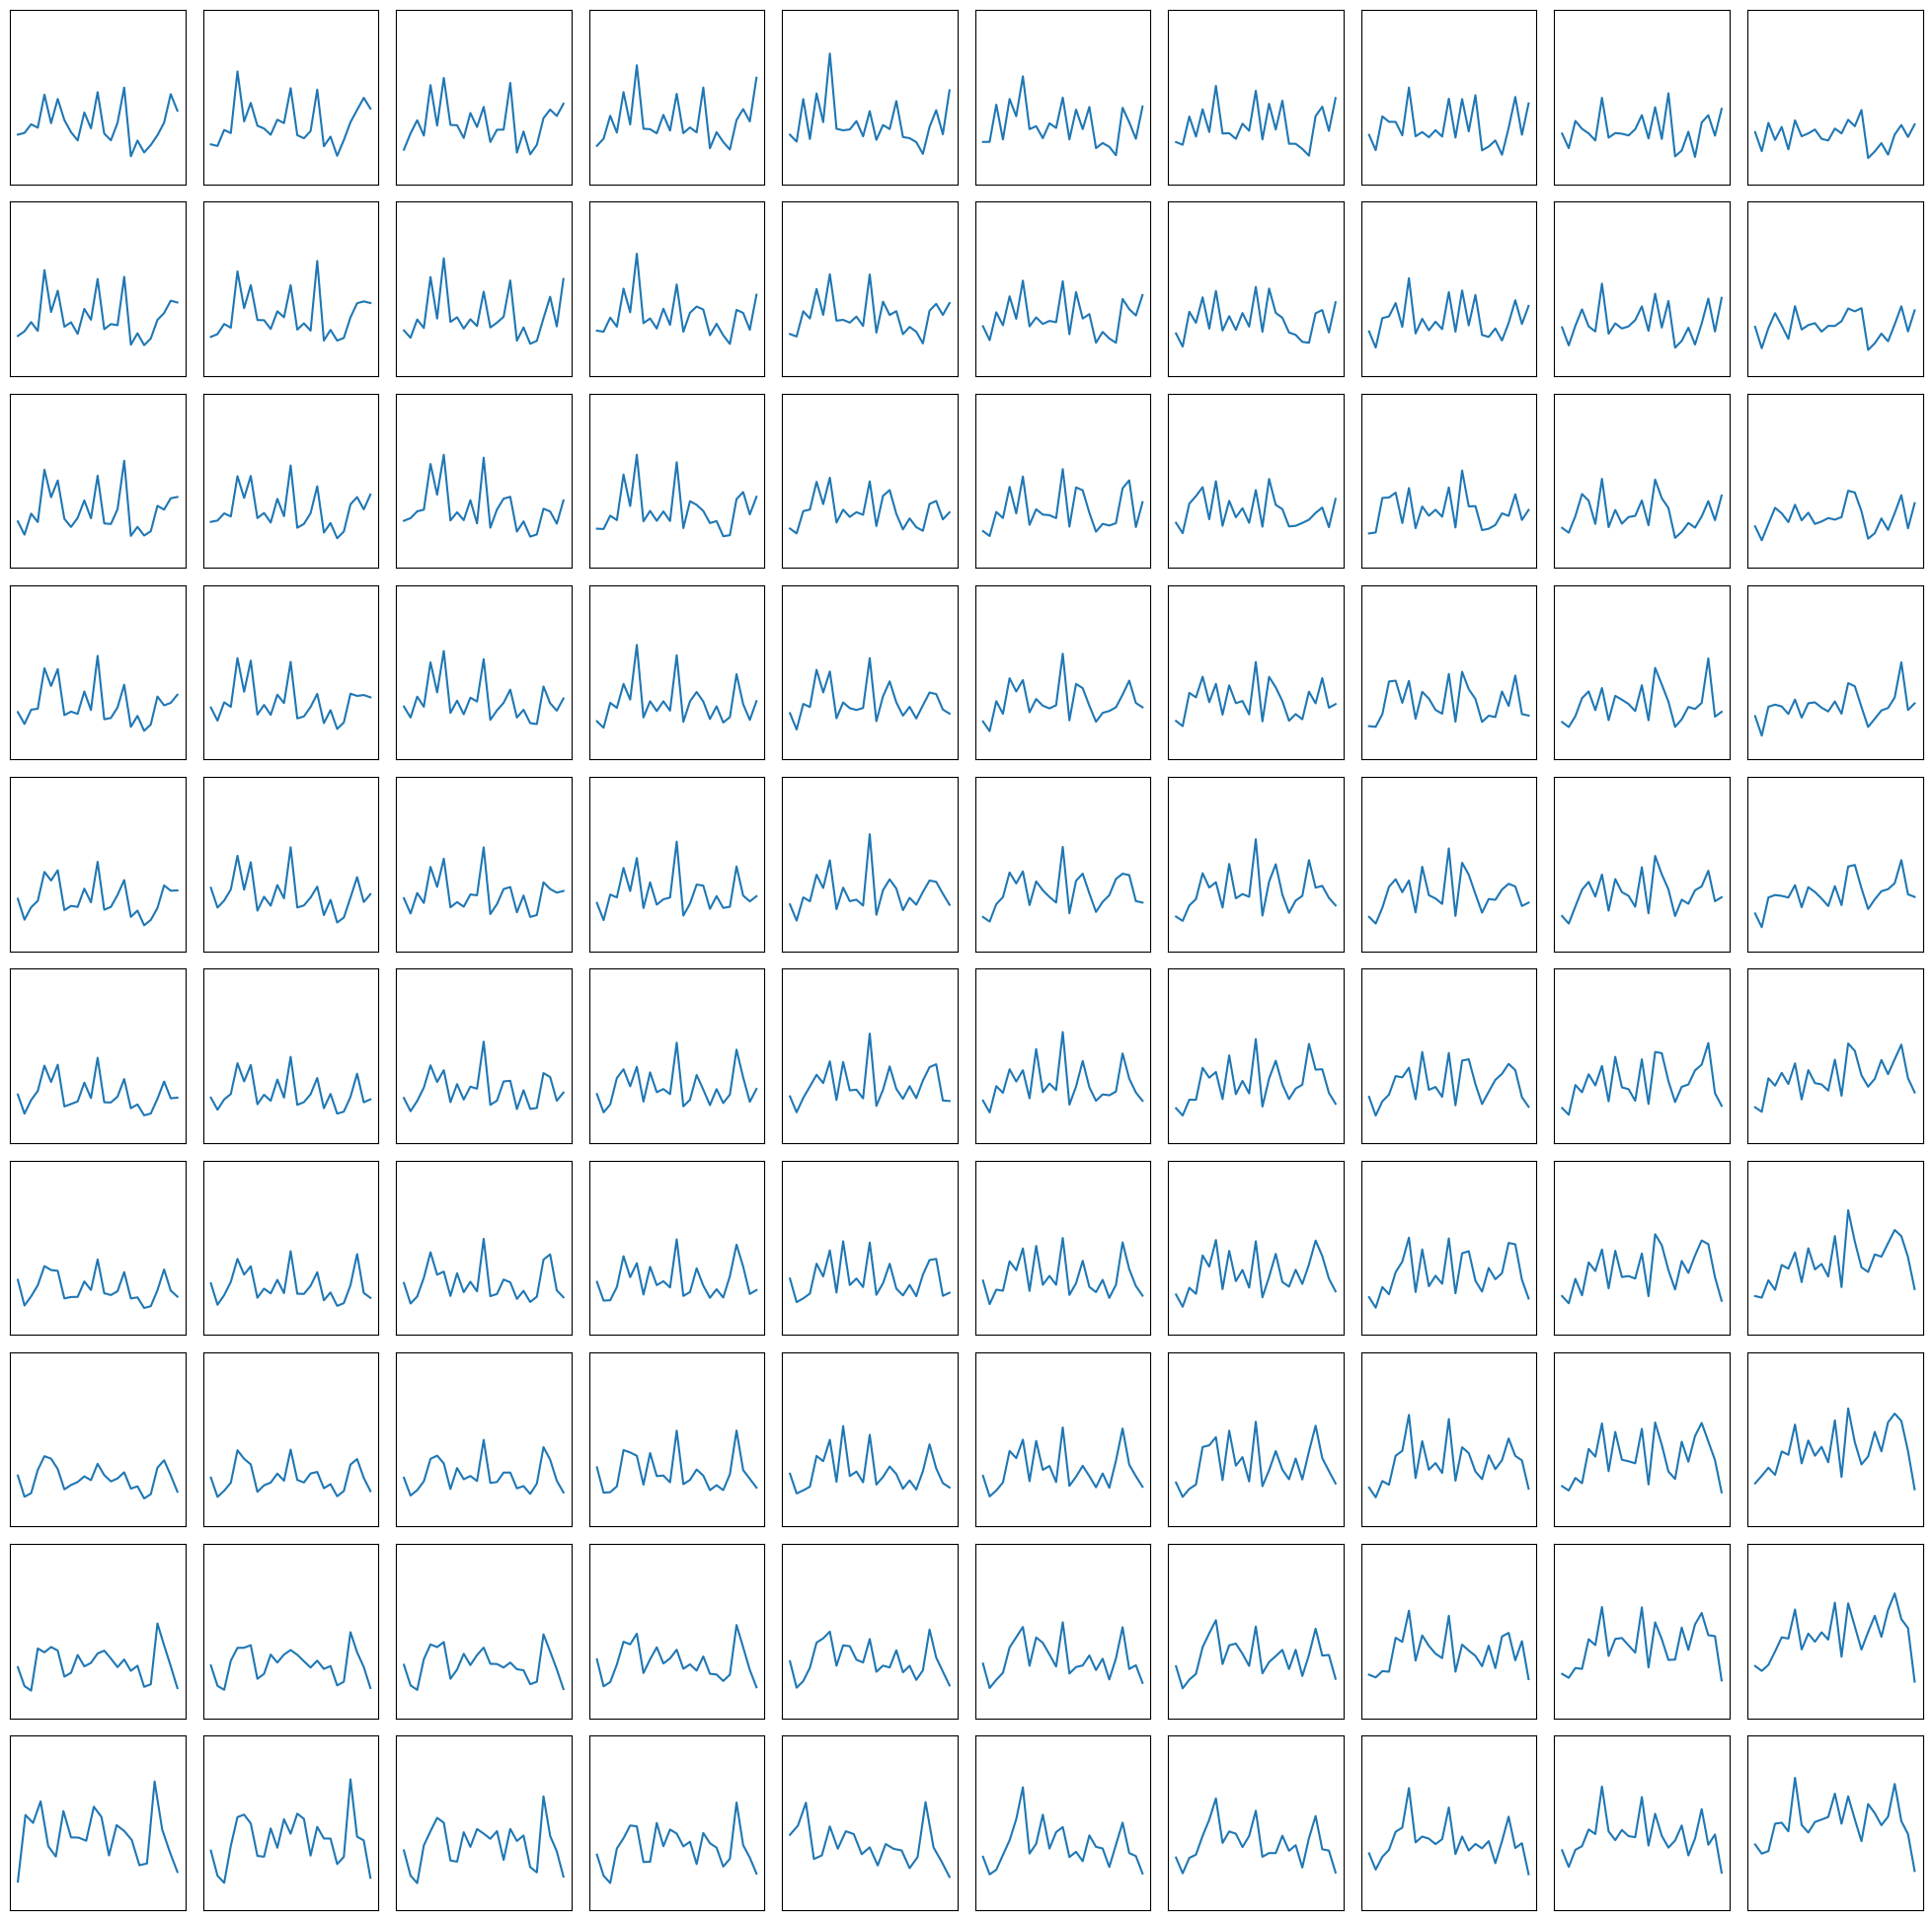

In [64]:
# Create a 10x10 grid of subplots
fig, axs = plt.subplots(10, 10, figsize=(25, 25))

# Iterate over each subplot
for i in range(10):
    for j in range(10):
        # Extract the i,j element from each dictionary value
        y = [v[i, j] for v in annual_averages.values()]

        # Generate x values
        x = list(annual_averages.keys())

        # Plot line graph on the i,j subplot
        axs[i, j].plot(x, y)

        # Remove title, xticks, xlabels, yticks, ylabels
        axs[i, j].set_title('')
        axs[i, j].set_xticks([])
        axs[i, j].set_xlabel('')
        axs[i, j].set_yticks([])
        axs[i, j].set_ylabel('')

        # Set y limit
        axs[i, j].set_ylim([0, 3])

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.show()

In [65]:
plt.close()